## **Uploading All files:**
Upload all test/train pickle files.

In [0]:
from google.colab import files
files.upload()

In [0]:
files.upload()

In [0]:
files.upload()

# **Understanding the Data**

## **Load Train:**
Load all pickle files and returns the pickle file as list

In [0]:
import pickle
def load_train(fName):
  """
    fName:Name/Relative Path for loading the file
  """
  pickle_in=open(fName,'rb')
  train_image=pickle.load(pickle_in)
  return train_image

In [0]:
"""
  train_image: Contains all training images.
  train_labels:Contains labels for training images
  testing_image: Contains all testing images.
"""
train_image=load_train('train_image.pkl')
train_label=load_train('train_label.pkl')
test_image=load_train('test_image.pkl')

## **See Count:**
Prints no. of images corresponding to each class(Training Class Distribution).

In [0]:
def see_count(li):
  count=[0 for _ in range(7)]
  for i in range(len(li)):
    count[li[i]]+=1
  print(count)
see_count(train_label)

[2000, 0, 2000, 2000, 0, 0, 2000]


## **Show Images:**
Plots 2 images of each category

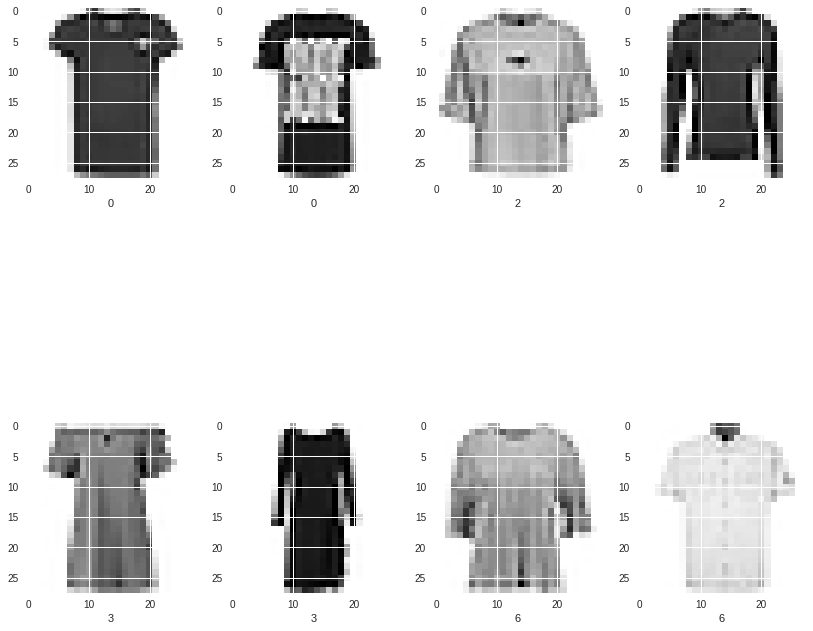

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def show_images():
  """
    columns:No of Columns in Figure
    rows:No of rows in figure.
  """
  columns = 4
  rows = 2
  fig=plt.figure(figsize=(14, 14))
  for i in range(1, columns*rows+1):
    img=train_image[i*1000-1]
    img=np.reshape(img,(28,28))
    fig.add_subplot(rows, columns, i)
    plt.xlabel(train_label[i*1000-1])
    plt.imshow(img,interpolation='nearest')
  plt.show()
show_images()

## **Encode Labels:**
Return a list with all labels between 0 and 3 (There are only 4 classes)

In [0]:
def encode_labels(train_label):
  train_new_label=train_label
  for i in range(len(train_label)):
    if train_label[i]==2:
      train_new_label[i]=1
    elif  train_label[i]==3:
      train_new_label[i]=2
    elif train_label[i]==6:
      train_new_label[i]=3
    else:continue
  return train_new_label

train_label=encode_labels(train_label)  

In [0]:
def save_pickle(obj,fName):
  """
    obj: list that will be dumped in pickle file
    fName:NAme of pickle file with extention
  """
  pickle_train_label=open(fName,"wb")
  pickle.dump(obj,pickle_train_label)
  pickle_train_label.close()
  
save_pickle(train_label,"train_label_enc.pkl")

# **Defining the Capsule Network: **

## **Installing and importing libraries**

In [0]:
!pip install torch
!pip install torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from numpy import prod
import imgaug as ia
from imgaug import augmenters as iaa
from datetime import datetime
from time import time
from IPython.display import clear_output
from IPython.display import set_matplotlib_close

## **Squash:**
The non-linear activation used in Capsule Network.
It drives the length of a large vector to near 1 and small vector to 0.
Returns the squashed vector.

In [0]:
def squash(vec,dim=-1):
  """
    dim: Axis along which vector is squashed.
    vec:N dim vector to be squashed
  """
  squared_normal=torch.sum(vec**2,dim=dim,keepdim=True)
  fn=squared_normal / (1 + squared_normal) * vec / (torch.sqrt(squared_normal) + 1e-8)
  return fn

## **Primary Capsules:**
Produces combinations of features from convolution.
Returns vector after being passed through 9x9x256 convolutional kernels or in general terms:
Returns: output tensor of shape=size=[batch, num_caps, dim_caps]

In [0]:
class PrimaryCapsules(nn.Module):
  def __init__(self,in_channels, out_channels, dim_caps,kernel_size=9, stride=2, padding=0):
    """
      dim:dimension of the output vectors of the capsules in this layer
      in_channels:Input channel size
      out_channels: output channel size
    """
    super(PrimaryCapsules,self).__init__()
    self.dim_caps=dim_caps
    self._caps_channel = int(out_channels / dim_caps)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    
  def forward(self,x):
    out=self.conv(x)
    out = out.view(out.size(0), self._caps_channel, out.size(2), out.size(3), self.dim_caps)
    #Arranging output as [batch, num_caps, dim_caps] and sqaushing it.
    out = out.view(out.size(0), -1, self.dim_caps)
    out=squash(out)
    return out

## ** Router:**
 The routing algorithm in Capsule network.
 Returns A Tensor of shape [batch_size, num_caps, dim_caps,1]

In [0]:
class Router(nn.Module):
  def __init__(self,in_dim, in_caps, num_caps, dim_caps, num_routing,device: torch.device):
      super(Router,self).__init__()
      self.in_dim = in_dim
      self.in_caps = in_caps
      self.num_caps = num_caps
      self.dim_caps = dim_caps
      self.num_routing = num_routing
      self.device = device
      self.W = nn.Parameter( 0.01 * torch.randn(1, num_caps, in_caps, dim_caps, in_dim ))
    
  def __repr__(self):
      # representation of router.
      tab= '  '
      line = '\n'
      next = ' -> '
      res = self.__class__.__name__ + '('
      res = res + line + tab + '(' + str(0) + '): ' + 'CapsuleLinear('
      res = res + str(self.in_dim) + ', ' + str(self.dim_caps) + ')'
      res = res + line + tab + '(' + str(1) + '): ' + 'Routing('
      res = res + 'Routing No =' + str(self.num_routing) + ')'
      res = res + line + ')'
      return res
  
  def forward(self,x):
    batch_size = x.size(0)
    x = x.unsqueeze(1).unsqueeze(4)
    # W @ x =(1, num_caps, in_caps, dim_caps, in_dim) @ (batch_size, 1, in_caps, in_dim, 1) =(batch_size, num_caps, in_caps, dim_caps, 1)
    u_hat = torch.matmul(self.W, x)
    u_hat = u_hat.squeeze(-1)
    #Prevent flow of Gradients
    temp_u_hat = u_hat.detach()
    b = torch.zeros(batch_size, self.num_caps, self.in_caps, 1).to(self.device)
    
    for route_iter in range(self.num_routing-1):
      sc = F.softmax(b, dim=1)
      # (batch_size, num_caps, in_caps, 1) * (batch_size, in_caps, num_caps, dim_caps) =(batch_size, num_caps, in_caps, dim_caps) sum across in_caps ->(batch_size, num_caps, dim_caps)
      vec = (sc * temp_u_hat).sum(dim=2)
      v = squash(vec)
      uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
      b += uv
      
    sc = F.softmax(b, dim=1)
    vec = (sc * u_hat).sum(dim=2)
    v = squash(vec)
    return v

## **CapsuleNet:**
Defining the architecture of network.

In [0]:
class CapsuleNet(nn.Module):
	def __init__(self, img_shape, channels, primary_dim, num_classes, out_dim, num_routing,device= torch.device, kernel_size=9):
     """
      channel: data size = [channels, width, height]
      num_classes: number of classes
      num_routing:number of routing calls
      img_shape:Shape of image from dataloader
      primary:Primary Capsule
      Decoder:Decoder part of capsulenet
     """
		super(CapsuleNet,self).__init__()
		self.img_shape = img_shape
		self.num_classes = num_classes;self.device = device
    
		self.conv1 = nn.Conv2d(img_shape[0], channels, kernel_size, stride=1, bias=True)
		self.relu = nn.ReLU(inplace=True)
    
		self.primary = PrimaryCapsules(channels, channels, primary_dim, kernel_size)
		
    
        
		primary_caps = int(channels / primary_dim * ( img_shape[1] - 2*(kernel_size-1) ) * ( img_shape[2] - 2*(kernel_size-1) ) / 4)
    
    
		self.digits = Router(primary_dim, primary_caps, num_classes, out_dim, num_routing,device=device)
    
		self.decoder = nn.Sequential(
			nn.Linear(out_dim * num_classes, 512),
			nn.ReLU(inplace=True),
			nn.Linear(512, 1024),
			nn.ReLU(inplace=True),
			nn.Linear(1024, int(prod(img_shape)) ),
			nn.Sigmoid()
		)

	def forward(self, x):
		out = self.conv1(x)
		out = self.relu(out)
		out = self.primary(out)
		out = self.digits(out)
		preds = torch.norm(out, dim=-1)

		# Reconstruct the predicted image and generate label
		_, max_length_idx = preds.max(dim=1)	
		y = torch.eye(self.num_classes).to(self.device)
		y = y.index_select(dim=0, index=max_length_idx).unsqueeze(2)

		reconstructions = self.decoder( (out*y).view(out.size(0), -1) )
		reconstructions = reconstructions.view(-1, *self.img_shape)

		return preds, reconstructions

## **Margin Loss:**
The length of the instantiation vector represents the
probability that a capsule’s entity exists, so we need
top-level capsule for digit class k to have a long
instantiation vector iff that digit is present in the image. Returns margin loss of function.

In [0]:
class MarginLoss(nn.Module):
    def __init__(self, size_average=False, loss_lambda=0.5):
            super(MarginLoss,self).__init__()
            self.size_average = size_average
            self.m_plus = 0.9
            self.m_minus = 0.1
            self.loss_lambda = loss_lambda
    
    def forward(self,inputs,labels):
          L_k = labels * F.relu(self.m_plus - inputs)**2 + self.loss_lambda * (1 - labels) * F.relu(inputs - self.m_minus)**2
          L_k.sum(dim=1)

          if self.size_average:return L_k.mean()
          else:return L_k.sum()

## **Capsule Loss:**
Returns Scalar value of  Margin loss + loss_lambda * reconstruction loss.

In [0]:
class CapsuleLoss(nn.Module):
	def __init__(self,loss_lambda=0.5, recon_loss_scale=5e-4, size_average=False):
		super(CapsuleLoss,self).__init__()
		self.size_average = size_average
		self.margin_loss = MarginLoss(size_average=size_average, loss_lambda=loss_lambda)
		self.reconstruction_loss = nn.MSELoss(size_average=size_average)
		self.recon_loss_scale = recon_loss_scale

	def forward(self,inputs, labels, images, reconstructions):
		margin_loss = self.margin_loss(inputs, labels)
		reconstruction_loss = self.reconstruction_loss(reconstructions, images)
		caps_loss = (margin_loss + self.recon_loss_scale * reconstruction_loss)

		return caps_loss

## **Delete Old:**
Deletes old models/Checkpoints and downloads model every 50 epochs.

In [0]:
def delete_old(li,epochs,accs):
  """
    SAVE_MODEL_PATH:Path for storing and accessing models
    DELETE_MODEL_PATH:Path for deleting previous models
  """
  SAVE_MODEL_PATH='Checkpoints/'
  if epochs%50==0:
    #files.download(os.path.join(SAVE_MODEL_PATH, f'{epochs}_{accs}.pth'));
    for i in range(30):
      epoch=li[0]
      accuracy=li[2]
      DELETE_MODEL_PATH=os.path.join(SAVE_MODEL_PATH, f'{epoch}_{accuracy}.pth')
      #if os.path.exists(DELETE_MODEL_PATH):
       # os.remove(DELETE_MODEL_PATH)
  

## **Save Model PY:**
Saves models as state dictionary so that they can be retrained.

In [0]:
def save_model_py(model,optimizer,loss,epoch,accuracy):
  SAVE_MODEL_PATH='Checkpoints/'
  if epoch%1000:
    PATH=os.path.join(SAVE_MODEL_PATH, f'{epoch}_{accuracy}_Load.pth')
    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss}, PATH)

## **Plot Epoch Loss:**
Plots train and test accuracy by accepting training/testing history.

In [0]:
import matplotlib.pyplot as plt
set_matplotlib_close(True)
from IPython.display import display
def plot_epoch_loss(history):
  """
    history: list of format [epochs,loss,epoch,phase:"train/test"]
  """
  x_train_acc=x_test_acc=[]
  x_train_loss=x_test_loss=[]
  y_train=y_test=[]
  for a in history:
    if a[3]=='train':
      x_train_acc.append(a[2]*100)
      x_train_loss.append(a[1])
      y_train.append(a[0])
    else:
      x_test_acc.append(a[2]*100)
      x_test_loss.append(a[1])
      y_test.append(a[0])
  plt.figure(1)
  plt.subplot(221)
  plt.plot(y_train,x_train_acc,color='r')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy')
  plt.subplot(222)
  plt.plot(y_test,x_test_acc,color='b')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Test Accuracy')
  plt.subplot(223)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train Loss')
  plt.plot(y_train,x_train_loss ,color='r')
  plt.subplot(224)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Test Loss')
  plt.plot(y_test,x_test_loss ,color='b')
  display(plt.show())

## **Trainer:**
Wrapper object for handling training and evaluation.Trains/tests the network and returns trained network.

In [0]:
import os
if not os.path.exists('Checkpoints/'):os.mkdir('Checkpoints/')
SAVE_MODEL_PATH='Checkpoints/'
history=[]
class Trainer:
	"""
	net:Capsule network object.
  loaders:list of DataLoaders
  img_shape:Shape of image
  critireon: Capsule Loss
  num_classes:Number of classes
	"""
	def __init__(self, loaders, batch_size,learning_rate, num_routing=3, lr_decay=0.9,num_classes=4, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), multi_gpu=(torch.cuda.device_count() > 1)):
		self.device = device
		self.multi_gpu = multi_gpu

		self.loaders = loaders
		img_shape = self.loaders['train'].dataset[0][0].numpy().shape
		
		self.net = CapsuleNet(img_shape=img_shape, channels=256, primary_dim=8, num_classes=num_classes, out_dim=16, num_routing=num_routing, device=self.device).to(self.device)
		if os.path.exists(os.path.join(SAVE_MODEL_PATH,'best_prev.pth')):MODEL_LOAD_PATH=os.path.join(SAVE_MODEL_PATH,'best_prev.pth');self.net = torch.load(MODEL_LOAD_PATH);print('Model Loaded')
		if self.multi_gpu:
			self.net = nn.DataParallel(self.net)
    
		self.criterion = CapsuleLoss(loss_lambda=0.5, recon_loss_scale=5e-4)
		self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
		self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=lr_decay)
		print(8*'#', 'PyTorch Model built'.upper(), 8*'#')
		print('Num params:', sum([prod(p.size()) for p in self.net.parameters()]))
	
	def __repr__(self):
		return repr(self.net)

	def run(self, epochs, classes):
		print(8*'#', 'Run started'.upper(), 8*'#')
		eye = torch.eye(len(classes)).to(self.device)
		
		for epoch in range(1, epochs+1):
			for phase in ['train', 'test']:
				print(f'{phase}ing...'.capitalize())
				if phase == 'train':
					self.net.train()
				else:
					self.net.eval()

				t0 = time()
				running_loss = 0.0
				correct = 0; total = 0
				for i, (images, labels) in enumerate(self.loaders[phase]):
					t1 = time()
					images, labels = images.to(self.device), labels.to(self.device)
					# One-hot encode labels
					labels = eye[labels]

					self.optimizer.zero_grad()

					outputs, reconstructions = self.net(images)
					loss = self.criterion(outputs, labels, images, reconstructions)

					if phase == 'train':
						loss.backward()
						self.optimizer.step()

					running_loss += loss.item()

					_, predicted = torch.max(outputs, 1)
					_, labels = torch.max(labels, 1)
					total += labels.size(0)
					correct += (predicted == labels).sum()
					accuracy = float(correct) / float(total)

					if phase == 'train':
						if i%100==0:clear_output();print(8*'#', 'Run started'.upper(), 8*'#');print(f'{phase}ing...'.capitalize());plot_epoch_loss(history);				
						print(f'Epoch {epoch}, Batch {i+1}, Loss {running_loss/(i+1)}',f'Accuracy {accuracy} Time {round(time()-t1, 3)}s');
				history.append([epoch,running_loss/i+1,accuracy,phase]);plot_epoch_loss(history);
				if epoch%10==0:torch.save(self.net, os.path.join(SAVE_MODEL_PATH, f'{epoch}_{accuracy}.pth'));delete_old(history,epoch,accuracy);#save_model_py(self.net,epoch,accuracy); 
				print(f'{phase.upper()} Epoch {epoch}, Loss {running_loss/(i+1)}',f'Accuracy {accuracy} Time {round(time()-t0, 2)}s')
        
			self.scheduler.step()
		now = str(datetime.now()).replace(" ", "-")
		error_rate = round((1-accuracy)*100, 2)
		torch.save(self.net, os.path.join(SAVE_MODEL_PATH,'best_prev_1.pth'))

		class_correct = list(0. for _ in classes)
		class_total = list(0. for _ in classes)
		for images, labels in self.loaders['test']:
			images, labels = images.to(self.device), labels.to(self.device)

			outputs, reconstructions = self.net(images)
			_, predicted = torch.max(outputs, 1)
			c = (predicted == labels).squeeze()
			for i in range(labels.size(0)):
				label = labels[i]
				class_correct[label] += c[i].item()
				class_total[label] += 1
		for i in range(len(classes)):
			print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]));return self.net


## **FashionMNIST:**
Loads Pickle File and returns image and label after reshaping.

In [0]:
class FashionMNIST(Dataset):
    def __init__(self, pickle_file_images,pickle_file_labels,train=False, transform=None):
        pickle_in=open(pickle_file_images,'rb')
        pickle_in_label=open(pickle_file_labels,'rb')
        self.train_image=pickle.load(pickle_in)
        self.label=pickle.load(pickle_in_label)
        self.transform = transform
        self.train=train
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
      image = self.train_image[idx]
      image=np.array(image,dtype=np.uint8)
      #image=image.reshape(28,28)
      #image=augment_img(image)
      image=image.reshape(28,28,1)
      if self.train:
        seq = iaa.Sequential([iaa.Fliplr(0.5),iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 0.5))),iaa.ContrastNormalization((0.75, 1.5)),iaa.Multiply((0.8, 1.2), per_channel=0.2),iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},rotate=(-25, 25),shear=(-8, 8))], random_order=True)
        images_aug = seq.augment_images([image])
        images_aug=images_aug[0]
        
      label = self.label[idx]
      if self.transform is not None:
          image = self.transform(image)
      return image, label

## **Train Test Split:**
Splits train images into training set and test set.

In [0]:
def train_test_split(train_images,train_labels,split_ratio=0.90):
  """
    train_images:Set of training images
    train_labels:training labels
    split_ratio:Training_set_size/total_size
  """
  split=int((1-split_ratio)*len(train_image))
  train_image_split=[]
  train_label_split=[]
  test_image_split=[]
  test_label_split=[]
  count=0
  np.random.seed(21)
  for i in range(len(train_labels)):
    if count<split:
      arr=[1,1,1,1,1,1,1,1,1,1,0,1,1]
      k=len(arr)
      in_train=arr[np.random.randint(k)]
      if in_train:
        train_image_split.append(train_images[i])
        train_label_split.append(train_labels[i])
      else:
          test_image_split.append(train_images[i])
          test_label_split.append(train_labels[i])
          count+=1
    else:
      train_image_split.append(train_images[i])
      train_label_split.append(train_labels[i])
  save_pickle(train_image_split,"train_image_nin.pkl")
  save_pickle(train_label_split,"train_label_nin.pkl")
  save_pickle(test_image_split,"test_image_nin.pkl")
  save_pickle(test_label_split,"test_label_nin.pkl")
  print("Train Class Distribution")
  see_count(train_label_split)
  print("Test Class Distribution")
  see_count(test_label_split)
  


In [0]:
train_test_split(train_image,train_label)

Train Class Distribution
[1856, 1866, 1833, 1840, 0, 0, 0]
Test Class Distribution
[144, 134, 167, 160, 0, 0, 0]


## **Loading the Data:**
Loads the pickle file and creates Dataloaders.
**Augmentation Used:**
Random Rotation,Random Vertical Flip,Random Vertical Flip,Color Jitter(adjust brightness,hue and contrast).

In [0]:
BatchSize=batch_size=64
size = 28
classes = list(range(4))
loader={}
mean, std = ( ( 0.5,), ( 0.5,) )
augmentation=transforms.Compose([transforms.RandomOrder([transforms.RandomVerticalFlip(p=0.001),transforms.RandomRotation(degrees=(-10,10)),transforms.RandomHorizontalFlip(p=0.2),transforms.ColorJitter(brightness=0,contrast=0)])])
trainset=FashionMNIST( pickle_file_images='train_image_nin.pkl',pickle_file_labels="train_label_nin.pkl",train=True, transform=transforms.Compose([transforms.ToPILImage(),augmentation,transforms.ToTensor()]))
loader['train'] = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,shuffle=True)
augmentation_2=transforms.Compose([transforms.RandomOrder([transforms.RandomVerticalFlip(p=0.001),transforms.RandomRotation(degrees=(-8,8)),transforms.RandomHorizontalFlip(p=0.2),transforms.ColorJitter(brightness=0,contrast=0)])])
testset=FashionMNIST( pickle_file_images='test_image_nin.pkl',pickle_file_labels="test_label_nin.pkl",train=False, transform=transforms.Compose([transforms.ToPILImage(),augmentation_2,transforms.ToTensor()]))
loader['test']= torch.utils.data.DataLoader(testset, batch_size=BatchSize,shuffle=False)

In [0]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

## **Calling Trainer**

######## RUN STARTED ########
Training...


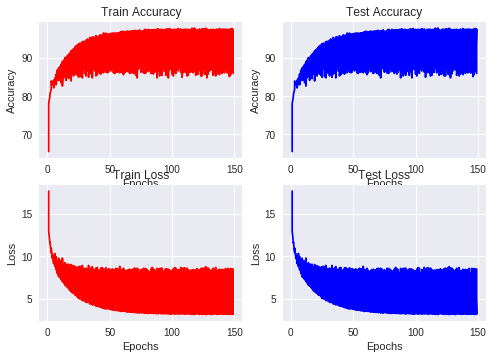

None

Epoch 150, Batch 101, Loss 2.1127347143569795 Accuracy 0.9774133663366337 Time 0.738s
Epoch 150, Batch 102, Loss 2.113704010552051 Accuracy 0.9774816176470589 Time 0.145s
Epoch 150, Batch 103, Loss 2.1092466590473955 Accuracy 0.9775485436893204 Time 0.14s
Epoch 150, Batch 104, Loss 2.117710386331265 Accuracy 0.9774639423076923 Time 0.142s
Epoch 150, Batch 105, Loss 2.113335709344773 Accuracy 0.9775297619047619 Time 0.142s
Epoch 150, Batch 106, Loss 2.121335225285224 Accuracy 0.9772995283018868 Time 0.141s
Epoch 150, Batch 107, Loss 2.125450965400054 Accuracy 0.9770735981308412 Time 0.141s
Epoch 150, Batch 108, Loss 2.1322050955560474 Accuracy 0.9768518518518519 Time 0.142s
Epoch 150, Batch 109, Loss 2.134756584779932 Accuracy 0.9764908256880734 Time 0.141s
Epoch 150, Batch 110, Loss 2.1334299499338325 Accuracy 0.9762784090909091 Time 0.141s
Epoch 150, Batch 111, Loss 2.134130604632266 Accuracy 0.9763513513513513 Time 0.141s
Epoch 150, Batch 112, Loss 2.1298913934401105 Accuracy 0.97656

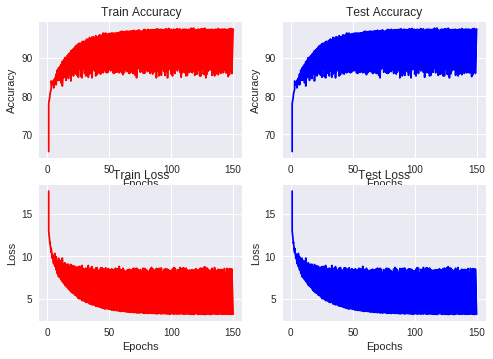

None

TRAIN Epoch 150, Loss 2.1309737552856576 Accuracy 0.9760649087221095 Time 34.91s
Testing...


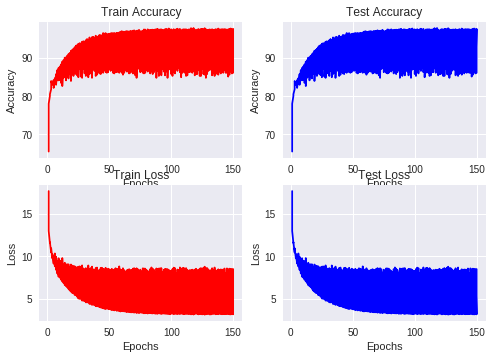

None

TEST Epoch 150, Loss 6.739929342269898 Accuracy 0.8611570247933884 Time 1.08s
Accuracy of     0 : 84 %


In [0]:
epochs=150
classes = list(range(4))
learning_rate=7e-4
lr_decay=0.95
history=[]
caps_net=Trainer(loader,num_classes=4,batch_size=128,learning_rate=learning_rate,num_routing=3, lr_decay=lr_decay)
net=caps_net.run(epochs=epochs, classes=classes)

In [0]:
print(net)

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (relu): ReLU(inplace)
  (primary): PrimaryCapsules(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (digits): Router(
    (0): CapsuleLinear(8, 16)
    (1): Routing(Routing No =3)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## **Inference:**
Loads pickle file and generates prediction.

In [0]:
def inference(fName):
  final_label=[]
  decode=[0,2,3,6]
  test_image=load_train(fName)
  for idx in range(len(test_image)):
    image=test_image[idx]
    image=np.array(image,dtype=np.uint8)
    image=torch.from_numpy(image)
    image=image.type(torch.cuda.FloatTensor)
    image=image.reshape(1,1,28,28)
    outputs, reconstructions = net(image)
    _, predicted = torch.max(outputs, 1)
    final_prediction=decode[predicted]
    final_label.append(final_prediction)
  save_pickle(final_label,"kartikdutt.pkl")

# **Create Submission**
Loads prediction and creates CSV file

In [0]:
import pandas as pd
def create_submission(fName):
  final_pred=load_train("kartikdutt.pkl")
  column_name=['image_index','class']
  df=pd.DataFrame(columns=column_name)
  for i in range(len(final_pred)):
    df=df.append({column_name[0]:i,column_name[1]:final_pred[i]},ignore_index=True)
  df.to_csv('kartik_dutt.csv',index=False)

In [0]:
inference('test_image.pkl')
create_submission("kartikdutt.pkl")

In [0]:
files.download('kartik_dutt.csv')